## Yann Cauchepin

Hi, here is my documented jupyter notebook which respond to the test request.

## Requirements

Before even running the following script, please process by:

- [ ] Installing the interested librairies. You can comment the next script to not bide your time.

- [ ] Replacing dataset path toward your local repositories.

In [1]:
!pip install scipy
!pip install tqdm
!pip install pandas
!pip install numpy
!pip install pyspark
!pip install catboost
!pip install shap
!pip install torch
!pip install captum
!pip install sklearn
!pip install mapie
!pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)


  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://g

In [2]:
metadata_path = "/media/yanncauchepin/ExternalDisk/Datasets/MachineLearningTables/lending_club/LCDataDictionary.xlsx"
data_path = "/media/yanncauchepin/ExternalDisk/Datasets/MachineLearningTables/lending_club/Loan_status_2007-2020Q3.csv"

Here

In [3]:
import pandas as pd
import numpy as np

In [4]:
metadata = pd.read_excel(metadata_path, index_col=0)
metadata = metadata.iloc[:-2,:]

In [5]:
#spark.stop

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LendingClubDataProcessing") \
    .getOrCreate()

df_spark = spark.read.csv(data_path, header=True, inferSchema=True)
print(f"Number of data: {df_spark.count()}")

24/06/21 14:50:08 WARN Utils: Your hostname, yanncauchepincomputer resolves to a loopback address: 127.0.1.1; using 192.168.43.208 instead (on interface wlp2s0)
24/06/21 14:50:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/21 14:50:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Number of data: 2925493


In [7]:
print(f"Metadata features: {len(metadata.index)}")
print(f"Data features: {len(df_spark.columns)}")

outer_features = [feature for feature in df_spark.columns if feature not in metadata.index]

print(f"Unknown data features: {outer_features} ({len(outer_features)})")
df_spark = df_spark.drop(*outer_features)

Metadata features: 151
Data features: 142
Unknown data features: ['_c0', 'verification_status_joint', 'total_rev_hi_lim', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med'] (14)


In [8]:
features_to_drop = ['grade', 'sub_grade']
df_spark = df_spark.drop(*features_to_drop)

In [9]:
all_features = [feature for feature in df_spark.columns if feature != 'loan_status']

In [10]:
value_counts = df_spark.groupBy('loan_status').count()
value_rate = value_counts.count() / df_spark.count()
print(f"Number of distincts values: {value_counts.count()} - {value_rate:.2e} %")
value_counts.show()

Number of distincts values: 12 - 4.10e-06 %


+--------------------+-------+
|         loan_status|  count|
+--------------------+-------+
|          Fully Paid|1497783|
|                NULL|      1|
|     In Grace Period|  10028|
|Does not meet the...|   1988|
|         Charged Off| 362547|
|  Late (31-120 days)|  16154|
|             Current|1031016|
|Does not meet the...|    761|
|   Late (16-30 days)|   2719|
|             Default|    433|
|              Issued|   2062|
|            Oct-2015|      1|
+--------------------+-------+



In [11]:
'''
mapping = {
    'Fully Paid': 0,
    'Charged Off': 1,
    'Current': np.nan,
    'Late (31-120 days)': np.nan,
    'In Grace Period': np.nan,
    'Late (16-30 days)': np.nan,
    'Issued': np.nan,
    'Does not meet the credit policy. Status:Fully Paid': np.nan,
    'Does not meet the credit policy. Status:Charged Off': np.nan,
    'Default': np.nan,
    'Oct-2015': np.nan
}
'''

from pyspark.sql.functions import when
df_spark = df_spark.withColumn("loan_status", when(df_spark["loan_status"] == "Fully Paid", 0)
                   .when(df_spark["loan_status"] == "Charged Off", 1)
                   .otherwise(np.nan))

In [12]:
df_spark = df_spark.fillna({col: "nan" if df_spark.schema[col].dataType == 'string' else np.nan for col in all_features})

In [13]:
value_counts = df_spark.groupBy('loan_status').count()
value_rate = value_counts.count() / df_spark.count()
print(f"Number of distincts values: {value_counts.count()} - {value_rate:.2e} %")
value_counts.show()

Number of distincts values: 3 - 1.03e-06 %


+-----------+-------+
|loan_status|  count|
+-----------+-------+
|        0.0|1497783|
|        NaN|1065163|
|        1.0| 362547|
+-----------+-------+



In [14]:
df_spark.dtypes

[('id', 'string'),
 ('loan_amnt', 'int'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'double'),
 ('term', 'string'),
 ('int_rate', 'string'),
 ('installment', 'double'),
 ('emp_title', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'string'),
 ('verification_status', 'string'),
 ('issue_d', 'string'),
 ('loan_status', 'double'),
 ('pymnt_plan', 'string'),
 ('url', 'string'),
 ('purpose', 'string'),
 ('title', 'string'),
 ('zip_code', 'string'),
 ('addr_state', 'string'),
 ('dti', 'string'),
 ('delinq_2yrs', 'double'),
 ('earliest_cr_line', 'string'),
 ('fico_range_low', 'string'),
 ('fico_range_high', 'int'),
 ('inq_last_6mths', 'int'),
 ('mths_since_last_delinq', 'int'),
 ('mths_since_last_record', 'int'),
 ('open_acc', 'int'),
 ('pub_rec', 'int'),
 ('revol_bal', 'int'),
 ('revol_util', 'string'),
 ('total_acc', 'string'),
 ('initial_list_status', 'string'),
 ('out_prncp', 'string'),
 ('out_prncp_inv', 'double'),
 ('total_pymnt', 'double'),
 ('

In [15]:
df = df_spark.sample(fraction=0.05, seed=1)
print(f"Number of data: {df.count()}")

Number of data: 145983


In [16]:
df = df.dropna(subset=['loan_status'])
print(f"Number of data: {df.count()}")

Number of data: 92781


In [17]:
features = df.select(all_features)
features_collected = features.collect()
target = df.select('loan_status')
target_collected = target.collect()

24/06/21 14:51:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [18]:
X = np.array([list(feature) for feature in features_collected])

In [19]:
y = np.array([feature['loan_status'] for feature in target_collected])

In [20]:
X.shape

(92781, 125)

In [21]:
y.shape

(92781,)

In [22]:
categorical_features = [feature for (feature, dtype) in df.dtypes if dtype=='string']

In [23]:
from catboost import Pool, CatBoostClassifier

pool = Pool(data=X, label=y, feature_names=all_features, cat_features=categorical_features)

catboost_model = CatBoostClassifier(iterations=100)
catboost_model.fit(pool)

Learning rate set to 0.5
0:	learn: 0.1319934	total: 270ms	remaining: 26.7s
1:	learn: 0.0766225	total: 377ms	remaining: 18.5s
2:	learn: 0.0388028	total: 491ms	remaining: 15.9s
3:	learn: 0.0303303	total: 570ms	remaining: 13.7s
4:	learn: 0.0235605	total: 638ms	remaining: 12.1s
5:	learn: 0.0206519	total: 713ms	remaining: 11.2s
6:	learn: 0.0195695	total: 788ms	remaining: 10.5s
7:	learn: 0.0189217	total: 853ms	remaining: 9.81s
8:	learn: 0.0175497	total: 926ms	remaining: 9.36s
9:	learn: 0.0175093	total: 998ms	remaining: 8.98s
10:	learn: 0.0167146	total: 1.07s	remaining: 8.68s
11:	learn: 0.0158007	total: 1.15s	remaining: 8.43s
12:	learn: 0.0157843	total: 1.22s	remaining: 8.15s
13:	learn: 0.0123135	total: 1.29s	remaining: 7.92s
14:	learn: 0.0123132	total: 1.36s	remaining: 7.72s
15:	learn: 0.0120829	total: 1.44s	remaining: 7.58s
16:	learn: 0.0108746	total: 1.51s	remaining: 7.38s
17:	learn: 0.0108745	total: 1.56s	remaining: 7.09s
18:	learn: 0.0108745	total: 1.62s	remaining: 6.91s
19:	learn: 0.010

In [24]:
import shap
explainer = shap.Explainer(catboost_model)
shap_values = explainer.shap_values(X)

In [25]:
sum_over_feature = np.sum(np.abs(shap_values), axis=0)
feature_importance = pd.DataFrame(data=sum_over_feature, index=all_features, columns=['feature_importance'])
feature_importance = feature_importance[feature_importance['feature_importance']>0]
feature_importance = feature_importance.sort_values(by='feature_importance', ascending=False)
feature_importance.shape
feature_importance

,feature_importance
total_rec_prncp,417046.553348
recoveries,149158.378179
last_fico_range_low,135989.706385
loan_amnt,128005.130072
funded_amnt_inv,93815.640670
...,...
hardship_loan_status,1.477193
fico_range_low,0.305097
open_acc_6m,0.073228
verification_status,0.000302


In [26]:
feature_importance['cumulative_sum'] = feature_importance['feature_importance'].cumsum()
total_sum = feature_importance['feature_importance'].sum()
feature_importance['rate'] = feature_importance['cumulative_sum'] / total_sum
feature_importance

,feature_importance,cumulative_sum,rate
total_rec_prncp,417046.553348,4.170466e+05,0.302733
recoveries,149158.378179,5.662049e+05,0.411007
last_fico_range_low,135989.706385,7.021946e+05,0.509721
loan_amnt,128005.130072,8.301998e+05,0.602640
funded_amnt_inv,93815.640670,9.240154e+05,0.670740
...,...,...,...
hardship_loan_status,1.477193,1.377605e+06,1.000000
fico_range_low,0.305097,1.377605e+06,1.000000
open_acc_6m,0.073228,1.377605e+06,1.000000
verification_status,0.000302,1.377605e+06,1.000000


In [27]:
threshold = 0.9
selected_features = feature_importance[feature_importance['rate'] < threshold].index
selected_features
len(selected_features)

17

In [28]:
features_to_drop = [feature for feature in all_features if feature not in selected_features]
features_to_drop
len(features_to_drop)

108

In [29]:
df_spark = df_spark.drop(*features_to_drop)

In [30]:
def to_float(value):
    try:
        return float(value)
    except ValueError:
        return np.nan

from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

to_float_udf = udf(to_float, FloatType())
df_spark = df_spark.withColumn("last_fico_range_high", to_float_udf(df_spark["last_fico_range_high"]))
df_spark = df_spark.withColumn("last_pymnt_amnt", to_float_udf(df_spark["last_pymnt_amnt"]))

In [31]:
df_spark.createOrReplaceTempView("lending_club")

In [32]:
sql_expression = """
CASE
    WHEN last_pymnt_d LIKE 'Jan-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 0/12
    WHEN last_pymnt_d LIKE 'Feb-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 1/12
    WHEN last_pymnt_d LIKE 'Mar-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 2/12
    WHEN last_pymnt_d LIKE 'Apr-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 3/12
    WHEN last_pymnt_d LIKE 'May-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 4/12
    WHEN last_pymnt_d LIKE 'Jun-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 5/12
    WHEN last_pymnt_d LIKE 'Jul-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 6/12
    WHEN last_pymnt_d LIKE 'Aug-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 7/12
    WHEN last_pymnt_d LIKE 'Sep-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 8/12
    WHEN last_pymnt_d LIKE 'Oct-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 9/12
    WHEN last_pymnt_d LIKE 'Nov-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 10/12
    WHEN last_pymnt_d LIKE 'Dec-%' THEN CAST(SUBSTRING(last_pymnt_d, 5) AS FLOAT) + 11/12
    ELSE NULL
END AS last_pymnt_d_num
"""
df_spark = spark.sql(f"""
SELECT *, {sql_expression}
FROM lending_club
""")

df_spark = df_spark.drop("last_pymnt_d")
df_spark = df_spark.withColumnRenamed('last_pymnt_d_num', 'last_pymnt_d')

In [33]:
sql_expression = """
CASE
    WHEN last_credit_pull_d LIKE 'Jan-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 0/12
    WHEN last_credit_pull_d LIKE 'Feb-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 1/12
    WHEN last_credit_pull_d LIKE 'Mar-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 2/12
    WHEN last_credit_pull_d LIKE 'Apr-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 3/12
    WHEN last_credit_pull_d LIKE 'May-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 4/12
    WHEN last_credit_pull_d LIKE 'Jun-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 5/12
    WHEN last_credit_pull_d LIKE 'Jul-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 6/12
    WHEN last_credit_pull_d LIKE 'Aug-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 7/12
    WHEN last_credit_pull_d LIKE 'Sep-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 8/12
    WHEN last_credit_pull_d LIKE 'Oct-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 9/12
    WHEN last_credit_pull_d LIKE 'Nov-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 10/12
    WHEN last_credit_pull_d LIKE 'Dec-%' THEN CAST(SUBSTRING(last_credit_pull_d, 5) AS FLOAT) + 11/12
    ELSE NULL
END AS last_credit_pull_d_num
"""
df_spark = spark.sql(f"""
SELECT *, {sql_expression}
FROM lending_club
""")

df_spark = df_spark.drop("last_credit_pull_d")
df_spark = df_spark.withColumnRenamed('last_credit_pull_d_num', 'last_credit_pull_d')

In [34]:
df_spark = df_spark.drop("last_pymnt_d")
df_spark = df_spark.withColumnRenamed('last_pymnt_d_num', 'last_pymnt_d')

In [35]:
convert_to_float_rate = udf(lambda x: float(x.replace('%', '')) / 100, FloatType())
df_spark = df_spark.withColumn('int_rate', convert_to_float_rate(df_spark['int_rate']))

In [36]:
from pyspark.ml.feature import Imputer

numerical_selected_features = [feature for (feature, dtype) in df_spark.dtypes if (dtype!='string' and feature !='loan_status')]

imputer = Imputer(
    inputCols=numerical_selected_features,
    outputCols=numerical_selected_features
).setStrategy("mean")

df_spark = imputer.fit(df_spark).transform(df_spark)

In [37]:
"""from pyspark.sql.functions import isnan
for feature, dtype in df_spark.dtypes:
    print("====================================")
    print(f"FEATURE: {feature}")
    if dtype=='string':
        value_counts = df_spark.groupBy(feature).count()
        value_rate = value_counts.count() / df_spark.count()
        print(f"Number of distincts values: {value_counts.count()} - {value_rate:.2e} %")
        value_counts.show()
    nan_count = df_spark.filter(df_spark[feature].isNull() | isnan(df_spark[feature])).count()
    nan_rate = nan_count / df_spark.count()
    print(f"{nan_count} NaN - {nan_rate:.2e} %")
    print("\n")"""

'from pyspark.sql.functions import isnan\nfor feature, dtype in df_spark.dtypes:\n    print("====================================")\n    print(f"FEATURE: {feature}")\n    if dtype==\'string\':\n        value_counts = df_spark.groupBy(feature).count()\n        value_rate = value_counts.count() / df_spark.count()\n        print(f"Number of distincts values: {value_counts.count()} - {value_rate:.2e} %")\n        value_counts.show()\n    nan_count = df_spark.filter(df_spark[feature].isNull() | isnan(df_spark[feature])).count()\n    nan_rate = nan_count / df_spark.count()\n    print(f"{nan_count} NaN - {nan_rate:.2e} %")\n    print("\n")'

In [38]:
df = df_spark.sample(fraction=0.005, seed=1)
print(f"Number of data: {df.count()}")
df = df.dropna(subset=['loan_status'])
print(f"Number of data: {df.count()}")

Number of data: 14518


Number of data: 9247


In [39]:
features = [feature for feature in list(df_spark.columns) if feature != 'loan_status']
features_collected = df.select(features).collect()
target_collected = df.select('loan_status').collect()

In [40]:
X = np.array([list(feature) for feature in features_collected])
y = np.array([feature['loan_status'] for feature in target_collected])
y = y.astype(int)

In [43]:
classes_ = np.unique(y)

In [86]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from captum.attr import IntegratedGradients
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from mapie.classification import MapieClassifier
from sklearn.calibration import CalibratedClassifierCV
from skopt import BayesSearchCV
import matplotlib.pyplot as plt

torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_sizes, activation_name, p_dropout):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layer_sizes = hidden_layer_sizes
        if isinstance(self.hidden_layer_sizes, str):
            self.hidden_layer_sizes = eval(self.hidden_layer_sizes)
        self.activation_name = activation_name
        self.p_dropout = p_dropout
        if activation_name == "Relu":
            self.activation = nn.ReLU()
        elif activation_name == "Sigmoid":
            self.activation = nn.Sigmoid()
        elif activation_name == "Softmax":
            self.activation = nn.Softmax(dim=1)
        elif activation_name == "Tanh":
            self.activation = nn.Tanh()
        elif activation_name == "Leaky_relu":
            self.activation = nn.LeakyReLU()
        else:
            raise ValueError(f'Unsupported activation: {self.activation_name}')
        layers = []
        layers.append(nn.Linear(self.input_size, self.hidden_layer_sizes[0]))
        layers.append(self.activation)
        for i in range(len(self.hidden_layer_sizes) - 1):
            layers.append(nn.Linear(self.hidden_layer_sizes[i], self.hidden_layer_sizes[i + 1]))
            layers.append(self.activation)
            layers.append(nn.Dropout(p=self.p_dropout))
        layers.append(nn.Linear(self.hidden_layer_sizes[-1], self.output_size))
        self.model = nn.Sequential(*layers)
        self.sigmoid = nn.Sigmoid()
        

    def forward_proba(self, X):
        output = self.model(X)
        output = self.output_activation(output)
        return output
    
    
    def forward(self, X):
        output = self.model(X)
        output = self.output_activation(output)
        return output


class MLPEstimatorSklearn():
    def __init__(self, **params):
        self.input_size = params.get("input_size")
        self.output_size = params.get("output_size")
        self.hidden_layer_sizes = params.get("hidden_layer_sizes", (60, 60))
        self.activation_name = params.get("activation_name", "Relu")
        self.loss = params.get("loss", "binary_cross_entropy")
        self.optimizer_name = params.get("optimizer_name", "Adam")
        self.learning_rate = params.get("learning_rate", 1e-3)
        self.batch_size = params.get("batch_size", 50)
        self.weight_decay = params.get("weight_decay", 0)
        self.p_dropout = params.get("p_dropout", 0.2)
        self.early_stopping = params.get("early_stopping", True)
        self.epochs = params.get("epochs", 200)
        self.patience = params.get("patience", 10)
        self.verbose = params.get("verbose", True)
        self.classes_ = classes_

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = MLP(self.input_size, self.output_size, self.hidden_layer_sizes, self.activation_name, self.p_dropout).to(self.device)

        if self.loss == "binary_cross_entropy":
            self.criterion = nn.BCELoss()
        else:
            raise ValueError(f"Unsupported loss: {self.loss}")

        if self.optimizer_name == "SGD":
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9, weight_decay=self.weight_decay)
        elif self.optimizer_name == "Adam":
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")
            
    def next_batch(self, inputs, targets, batchSize):
        inputs_np = inputs.values if isinstance(inputs, pd.DataFrame) else inputs
        targets_np = targets.values if isinstance(targets, pd.DataFrame) else targets
        inputs_tensor = torch.from_numpy(inputs_np).float()
        targets_tensor = torch.from_numpy(targets_np).float().squeeze()
        for i in range(0, inputs_tensor.shape[0], batchSize):
            yield (inputs_tensor[i:i + batchSize], targets_tensor[i:i + batchSize])

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        running_losses = list()
        if self.early_stopping:
            best_loss = float('inf')
            count = 0
        if self.verbose:
            epoch_iterator = tqdm(range(self.epochs), desc="Training Epochs", unit="epoch")
        else:
            epoch_iterator = range(self.epochs)
        for epoch in epoch_iterator:
            samples = 0
            train_loss = 0.0
            self.model.train(True)
            for i, (batchX, batchY) in enumerate(self.next_batch(X, y, self.batch_size)):
                batchX = batchX.to(self.device)
                batchY = batchY.to(self.device)
                batchY.requires_grad = True
                print(f"##########{batchY.shape}")
                self.optimizer.zero_grad()
                outputs = self.model(batchX)
                loss = self.criterion(outputs, batchY)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                samples += batchY.size(0)
            running_loss = train_loss / samples
            running_losses.append(running_loss)
            if self.verbose:
                epoch_iterator.set_postfix(train_loss=running_loss)
            if self.early_stopping:
                if running_loss < best_loss:
                    best_loss = running_loss
                    count = 0
                else:
                    count += 1
                if count >= self.patience:
                    #print("Early stopping due to no improvement in loss.")
                    break
        if self.verbose:
            epoch_iterator.close()
        self.running_losses = [loss for loss in running_losses if loss <= best_loss]
        return self

    def predict(self, X):
        self.model.eval()
        X = torch.from_numpy(X).float().to(self.device)
        y_pred = self.model.forward(X)
        if self.device == "cpu":
            y_pred = y_pred.cpu().detach().numpy()
        else:
            y_pred = y_pred.detach().numpy()
        return y_pred.astype(int)

    def predict_proba(self, X):
        self.model.eval()
        X = torch.from_numpy(X).float().to(self.device)
        y_proba = self.model.forward_proba(X)
        if self.device == "cpu":
            y_proba = y_proba.cpu().detach().numpy()
        else:
            y_proba = y_proba.detach().numpy()
        return y_proba

    def get_params(self, deep=True):
        params = {
            "input_size": self.input_size,
            "output_size": self.output_size,
            "hidden_layer_sizes": self.hidden_layer_sizes,
            "activation_name": self.activation_name,
            "loss": self.loss,
            "optimizer_name": self.optimizer_name,
            "learning_rate": self.learning_rate,
            "batch_size": self.batch_size,
            "weight_decay": self.weight_decay,
            "p_dropout": self.p_dropout,
            "early_stopping": self.early_stopping,
            "epochs": self.epochs,
            "patience": self.patience,
            "verbose": self.verbose
        }
        return params

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
        return self

    def get_model(self):
        return self.model
    
class MLPBinaryClassifier():
    def __init__(self, X, y, split_test, **params):
        self.model = MLPEstimatorSklearn(**params)
        self.X = X
        self.y = y
        self.y = MLPBinaryClassifier.float_to_class(self.y).ravel()
        
        self.split_test = split_test
        self.split_data()
        
        self.standardize(self.X_train)
        self.X_train_standard = self.standardize_X(self.X_train)
        self.y_train_standard = self.y_train


    @staticmethod
    def float_to_class(y):
        threshold = 0.5
        return (y >= threshold).astype(int)
    
    def split_data(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=self.split_test, shuffle=True, random_state=1, stratify=y)

    def standardize(self, X):
        self.scaler_X_train = StandardScaler()
        self.scaler_X_train.fit(X)         


    def standardize_X(self, X):
        X_new = self.scaler_X_train.transform(X)
        return X_new
    


    def bayes_search(self, param_bayes, n_iter, n_points=1, cv=5, scoring='accuracy',
                 verbose=3, n_jobs=1) :
        cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
        bayes_search = BayesSearchCV(self.model, param_bayes, n_iter=n_iter,
                                     n_points=n_points, cv=cv, scoring=scoring,
                                     verbose=verbose, return_train_score=True,
                                     n_jobs=n_jobs, random_state=1)
        bayes_search.fit(self.X_train_standard, self.y_train_standard)
        results_df = pd.DataFrame(bayes_search.cv_results_)
        self.model = bayes_search.best_estimator_
        print(f'Best hyperparameters bayes search : {bayes_search.best_params_}')
        return results_df

    def randomized_search(self, param_randomized, n_iter, cv=5, scoring='accuracy',
                      verbose=3, n_jobs=1) :
        cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
        randomized_search = RandomizedSearchCV(self.model, param_randomized,
                                               n_iter=n_iter, cv=cv, scoring=scoring,
                                               verbose=verbose, return_train_score=True,
                                               n_jobs=n_jobs, random_state=1)
        randomized_search.fit(self.X_train_standard, self.y_train_standard)
        results_df = pd.DataFrame(randomized_search.cv_results_)
        self.model = randomized_search.best_estimator_
        print(f'Best hyperparameters randomized search : {randomized_search.best_params_}')
        return results_df

    def fit(self):
        self.model.fit(self.X_train_standard, self.y_train_standard)

    def predict(self, X):
        X_standard = self.standardize_X(X)
        y_pred = self.model.predict(X_standard)
        return y_pred

    def predict_proba(self, X):
        X_standard = self.standardize_X(X)
        y_proba = self.model.predict_proba(X_standard)
        y_proba = np.array([self.unstandardize_y(item) for item in y_proba])
        return y_proba

    @staticmethod
    def compute_metrics(metric, y_true, y_pred):
        y_pred = MLPBinaryClassifier.float_to_class(y_pred)
        accuracy = metrics.accuracy_score(y_true, y_pred)
        precision = metrics.precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = metrics.recall_score(y_true, y_pred, average='weighted')
        f1 = metrics.f1_score(y_true, y_pred, average='weighted')
        metrics_dict = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
        }
        if metric != 'all':
            metrics_dict = {metric: metrics_dict[metric]}
        return metrics_dict


    def model_performance(self, metric='all'):
        y_pred_train = self.predict(self.X_train)
        scores_train = MLPBinaryClassifier.compute_metrics(metric, self.y_train, y_pred_train)
        y_pred_test = self.predict(self.X_test)
        scores_test = MLPBinaryClassifier.compute_metrics(metric, self.y_test, y_pred_test)
        data = {}
        for key, value in scores_train.items():
            data['Train Set - '+key] = [value]
        for key, value in scores_test.items():
            data['Test Set - '+key] = [value]
        df_scores = pd.DataFrame(data=data).T
        df_scores.columns = ['Scores']
        return df_scores

    def model_performance_test(self, X_test, y_test, metric='all'):
        y_pred_test = self.predict(X_test)
        scores_test = MLPBinaryClassifier.compute_metrics(metric, y_test, y_pred_test)
        data = {}
        for key, value in scores_test.items():
            data['Test Set - '+key] = [value]
        df_scores = pd.DataFrame(data=data).T
        df_scores.columns = ['Scores']
        return df_scores

    def receiver_operating_characteristics(self):
        y_pred_test = self.predict(self.X_test)
        fpr, tpr, thresholds = metrics.roc_curve(self.y_test, y_pred_test)
        plt.plot(fpr, tpr)
        plt.title("Receiver Operating Characteristics")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()

    def compute_integrated_gradients(self, X, baseline=None, steps=50):
        def preprocess_input(X):
            return torch.tensor(X, dtype=torch.float32)
        input_tensor = preprocess_input(X)
        if baseline is None:
            baseline = torch.zeros_like(input_tensor)
        integrated_gradients = IntegratedGradients(self.model.get_model())
        attributions = integrated_gradients.attribute(input_tensor, baseline, target=0, n_steps=steps)
        attributions_df = pd.DataFrame(attributions.cpu().detach().numpy(), columns=features)
        avg_attributions = attributions_df.mean(axis=0)
        sorted_attributions = avg_attributions.sort_values(ascending=False)
        return sorted_attributions

In [87]:
from scipy.stats import loguniform, uniform
from skopt.space import Real


params = {    
    "init" : {
        "input_size" : len(features),
        "output_size" : 1,
        "hidden_layer_sizes" : (60,60),
        "activation_name" : "Relu",
        "optimizer_name" : "Adam",
        "learning_rate" : 1e-3,
        "batch_size" : 50,
        "weight_decay" : 0,
        "p_dropout" : 0.3,
        "loss" : "binary_cross_entropy",
        "early_stopping" : True,
        "epochs" : 200,
        "patience" : 10,
        "verbose" : True
    },
    "randomized": {
        "hidden_layer_sizes" : [(10,),(50,),(100,),(10,10),(50,50),(60,60),(100,50),(100,100),(100,50,25)],
        "activation_name" :  ["Relu", "Sigmoid", "Tanh", "Leaky_relu", "Softmax"],
        "learning_rate" : loguniform(1e-4, 1e-1),
        "batch_size" : list(np.arange(10,500, 10)),
        "optimizer_name" : ["Adam", "SGD"],
        "alpha" : np.logspace(-3,0,19),
        "weight_decay" : loguniform(1e-5, 1),
        "p_dropout" : uniform(0, 0.4)   
    },
    "bayes": {
        "hidden_layer_sizes" : ["(10,)","(50,)","(100,)","(10,10)","(50,50)","(60,60)","(100,50)","(100,100)","(100,50,25)"],
        "activation_name" :  ["Relu", "Sigmoid", "Tanh", "Leaky_relu", "Softmax"],
        "learning_rate" : Real(1e-4, 1e-1, prior='log-uniform'),
        "batch_size" : list(np.arange(10,500, 10)),
        "optimizer_name" : ["Adam", "SGD"],
        "alpha" : np.logspace(-3,0,19),
        "weight_decay" : Real(1e-5, 1, prior='log-uniform'),
        "p_dropout" : Real(0, 0.4, prior='uniform')
    }
}
y = y.reshape(-1,1)
model_mlp = MLPBinaryClassifier(X=X, y=y, split_test=0.2, **params["init"])

In [88]:
n_iter = 5
n_points=1
cv=5
scoring='accuracy'
verbose=3
n_jobs=-1

In [59]:
# model_mlp.bayes_search(
#     param_bayes=params['bayes'],
#     n_iter=n_iter,
#     n_points=n_points,
#     cv=cv,
#     scoring=scoring,
#     n_jobs=n_jobs
# )

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [63]:
model_mlp.randomized_search(
    param_randomized=params['randomized'],
    n_iter=n_iter,
    cv=cv,
    scoring=scoring,
    n_jobs=n_jobs
)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Training Epochs:  40%|███▉      | 79/200 [00:05<00:08, 13.88epoch/s, train_loss=8.55e-6] 


Training Epochs:  23%|██▎       | 46/200 [00:06<00:23,  6.67epoch/s, train_loss=3.01e-5]

Training Epochs:   0%|          | 1/200 [00:00<00:45,  4.40epoch/s, train_loss=0.0068]5]

KeyboardInterrupt: 

In [50]:
model_mlp.model.get_params()

{'input_size': 16,
 'output_size': 1,
 'hidden_layer_sizes': (100, 100),
 'activation_name': 'Tanh',
 'loss': 'binary_cross_entropy',
 'optimizer_name': 'SGD',
 'learning_rate': 0.002352959348061621,
 'batch_size': 50,
 'weight_decay': 9.783797277120768e-05,
 'p_dropout': 0.05615477543809351,
 'early_stopping': True,
 'epochs': 200,
 'patience': 10,
 'verbose': True}

In [89]:
model_mlp.fit()

Training Epochs:   0%|                   | 0/200 [00:00<?, ?epoch/s]

##########torch.Size([50])


RuntimeError: "log_softmax_lastdim_kernel_impl" not implemented for 'Long'

In [65]:
model_mlp.model_performance()

,Scores
Train Set - Accuracy,0.979586
Train Set - Precision,0.980095
Train Set - Recall,0.979586
Train Set - F1,0.979169
Test Set - Accuracy,0.980541
Test Set - Precision,0.981003
Test Set - Recall,0.980541
Test Set - F1,0.980163


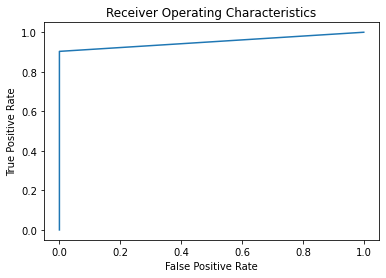

In [66]:
model_mlp.receiver_operating_characteristics()

In [54]:
df_test = df_spark.sample(fraction=0.05, seed=30)
df_test = df_test.dropna(subset=['loan_status'])
features_collected = df_test.select(features).collect()
X_test = np.array([list(feature) for feature in features_collected])
target_collected = df_test.select('loan_status').collect()
y_test = np.array([feature['loan_status'] for feature in target_collected])
y_test = y_test.astype(int)

In [55]:
model_mlp.model_performance_test(X_test, y_test)

,Scores
Test Set - Accuracy,0.976740
Test Set - Precision,0.977391
Test Set - Recall,0.976740
Test Set - F1,0.976157


In [56]:
single_value_collected = df_spark.limit(1).collect()[0]
single_value = np.array([value for key, value in single_value_collected.asDict().items() if key != 'loan_status']).reshape(1,-1)
single_value_target = np.array([value for key, value in single_value_collected.asDict().items() if key == 'loan_status'])

In [57]:
model_mlp.predict(single_value)

array([[0]])

In [58]:
model_mlp.compute_integrated_gradients(single_value)

funded_amnt_inv         4.944152e-09
funded_amnt             4.629140e-09
loan_amnt               1.646456e-09
total_rec_int           2.905649e-10
fico_range_high         2.280819e-11
last_fico_range_low     1.245976e-11
recoveries              0.000000e+00
mths_since_rcnt_il      0.000000e+00
mo_sin_old_rev_tl_op    0.000000e+00
int_rate               -5.668992e-15
last_credit_pull_d     -4.696943e-11
last_fico_range_high   -8.651511e-11
last_pymnt_amnt        -9.824349e-11
total_pymnt            -3.772133e-09
total_pymnt_inv        -4.536248e-09
total_rec_prncp        -4.989309e-09
dtype: float64

[CV 2/5] END activation_name=Tanh, alpha=0.21544346900318823, batch_size=50, hidden_layer_sizes=(100, 100), learning_rate=0.002352959348061621, optimizer_name=SGD, p_dropout=0.05615477543809351, weight_decay=9.783797277120768e-05;, score=(train=0.980, test=0.982) total time=  27.1s
[CV 1/5] END activation_name=Leaky_relu, alpha=0.31622776601683794, batch_size=430, hidden_layer_sizes=(100, 50, 25), learning_rate=0.0001972606689184097, optimizer_name=SGD, p_dropout=0.26866163896885376, weight_decay=0.0011453530979564342;, score=(train=0.956, test=0.936) total time=   6.5s
[CV 5/5] END activation_name=Tanh, alpha=0.21544346900318823, batch_size=50, hidden_layer_sizes=(100, 100), learning_rate=0.002352959348061621, optimizer_name=SGD, p_dropout=0.05615477543809351, weight_decay=9.783797277120768e-05;, score=(train=0.984, test=0.988) total time=  25.2s
[CV 3/5] END activation_name=Leaky_relu, alpha=0.31622776601683794, batch_size=430, hidden_layer_sizes=(100, 50, 25), learning_rate=0.000197